transform VED 7 from keras to pytorch 

In [1]:
import tensorflow as tf
from cbrain import *
import torch as to
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda
from cbrain.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler


import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import xarray as xr

import tensorflow.keras as ke


from cbrain.imports import *

from cbrain.utils import *

from cbrain.cam_constants import *

from cbrain.data_generator import DataGenerator
import pandas as ps

2022-11-02 10:34:21.122608: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# reparameterization trick of VAE 
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    based on VAE presented on keras webpage for keras version 1 /
    recent keras VAE version can be seen on
    https://keras.io/examples/generative/vae/
    """

    z_mean, z_log_var = args
    batch= K.shape(z_mean)[0]
    dim=K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon=K.random_normal(shape=(batch,dim)) # epsilion= random_normal distributed tensor
    sample_prob=z_mean+K.exp(0.5*z_log_var)*epsilon #exp= elementwise exponential
    return sample_prob


In [3]:
def sampling_to(mean,log_var):
    """
    reparameterization in pytorch
    author: G.Behrens 
    """
    z_mean=mean
    z_log_var =log_var
    batch= z_mean.size(dim=0) #K.shape(z_mean)[0]
    dim=z_mean.size(dim=1)
    eps=to.normal(mean=0.0,std=1.0,size=(batch,dim))
    sampling_prob=z_mean+to.exp(0.5*z_log_var)*eps
    return sampling_prob

In [4]:
# define some hyperparameter

original_dim_input=109  # CBRAIN input node size

original_dim_output=int(113) # CBRAIN output node size 


# network parameters
latent_dim=6
intermediate_dim = 492      
batch_size = 8821      
kl_weight=7.205750271814725e-05
lr_init=0.0006169518075083216
act='leaky_relu'

input_shape = (original_dim_input,)
decoder_input_shape=(latent_dim,)
out_shape=(original_dim_output,)

In [5]:
# build VED 7 in keras 
input_lay=Input(shape=input_shape, name='encoder_input')
x_0 =Dense(intermediate_dim, activation=act)(input_lay)
x_1 =Dense(intermediate_dim/2, activation=act)(x_0)
x_2 =Dense(intermediate_dim/4, activation=act)(x_1)
x_3 =Dense(intermediate_dim/8, activation=act)(x_2)
x_4 =Dense(intermediate_dim/16, activation=act)(x_3)
z_mean = Dense(latent_dim, name='z_mean')(x_4)
z_log_var = Dense(latent_dim, name='z_log_var')(x_4)



# reparametrization trick
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(input_lay, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
    
input_decoder=Input(shape=decoder_input_shape, name='decoder_input')
x_0 =Dense(intermediate_dim/16, activation=act)(input_decoder)
x_1 =Dense(intermediate_dim/8, activation=act)(x_0)
x_2 =Dense(intermediate_dim/4, activation=act)(x_1)
x_3 =Dense(intermediate_dim/2, activation=act)(x_2)
x_4 =Dense(intermediate_dim, activation=act)(x_3)


outputs_1= Dense(original_dim_output,activation=act)(x_4)
outputs_A = Dense(104,activation='linear')(outputs_1)
outputs_B = Dense(9,activation='relu')(outputs_1)
outputs= Concatenate()([outputs_A,outputs_B])
 
    
# instantiate encoder model
decoder = Model(input_decoder, outputs, name='decoder')
decoder.summary()
decoder_outputs=decoder(encoder(input_lay)[2])
VED_7=Model(input_lay,decoder_outputs, name='VED')
VED_7.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 109)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 492)          54120       ['encoder_input[0][0]']          
                                                                                                  
 dense_1 (Dense)                (None, 246)          121278      ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 123)          30381       ['dense_1[0][0]']                
                                                                                            

2022-11-02 10:35:25.882989: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# load weights into keras VED 7
VED_7.load_weights('real_geography/VEDs/VED_7/VED_7_weights.h5',by_name=True)
VED_7.summary()
VED_7_weights=VED_7.get_weights()



Model: "VED"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 109)]             0         
                                                                 
 encoder (Functional)        [(None, 6),               215575    
                              (None, 6),                         
                              (None, 6)]                         
                                                                 
 decoder (Functional)        (None, 113)               230346    
                                                                 
Total params: 445,921
Trainable params: 445,921
Non-trainable params: 0
_________________________________________________________________


import pytorch 

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [19]:
#build Encoder in pytorch
    
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.X_1=nn.Linear(109,VED_7_weights[0].shape[1])
        self.X_2=nn.Linear(VED_7_weights[0].shape[1],VED_7_weights[2].shape[1])
        self.X_3=nn.Linear(VED_7_weights[2].shape[1],VED_7_weights[4].shape[1])
        self.X_4=nn.Linear(VED_7_weights[4].shape[1],VED_7_weights[6].shape[1])
        self.X_5=nn.Linear(VED_7_weights[6].shape[1],VED_7_weights[8].shape[1])
        self.z_mean=nn.Linear(VED_7_weights[8].shape[1],VED_7_weights[10].shape[1])
        self.z_log_var=nn.Linear(VED_7_weights[8].shape[1],VED_7_weights[12].shape[1])
        
        

           
    def forward(self,x):
        
        x=F.leaky_relu(self.X_1(x),negative_slope=0.2)
        x=F.leaky_relu(self.X_2(x),negative_slope=0.2)
        x=F.leaky_relu(self.X_3(x),negative_slope=0.2)
        x=F.leaky_relu(self.X_4(x),negative_slope=0.2)
        x=F.leaky_relu(self.X_5(x),negative_slope=0.2)
        x_1=self.z_mean(x)
        x_2=self.z_log_var(x)
        x=sampling_to(x_1,x_2)
            
        return x

        
        
# build Decoder in pytorch        
        
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.X_1=nn.Linear(VED_7_weights[12].shape[1],VED_7_weights[14].shape[1])
        self.X_2=nn.Linear(VED_7_weights[14].shape[1],VED_7_weights[16].shape[1])
        self.X_3=nn.Linear(VED_7_weights[16].shape[1],VED_7_weights[18].shape[1])
        self.X_4=nn.Linear(VED_7_weights[18].shape[1],VED_7_weights[20].shape[1])
        self.X_5=nn.Linear(VED_7_weights[20].shape[1],VED_7_weights[22].shape[1])
        self.X_6=nn.Linear(VED_7_weights[22].shape[1],VED_7_weights[24].shape[1])
        self.X_7=nn.Linear(VED_7_weights[24].shape[1],VED_7_weights[26].shape[1])
        self.X_8=nn.Linear(VED_7_weights[24].shape[1],VED_7_weights[28].shape[1])


    def forward(self,x):
        x=F.leaky_relu(self.X_1(x),negative_slope=0.2)
        x=F.leaky_relu(self.X_2(x),negative_slope=0.2)
        x=F.leaky_relu(self.X_3(x),negative_slope=0.2)
        x=F.leaky_relu(self.X_4(x),negative_slope=0.2)
        x=F.leaky_relu(self.X_5(x),negative_slope=0.2)
        x=F.leaky_relu(self.X_6(x),negative_slope=0.2)

        x_1=self.X_7(x)
        x_2=F.relu(self.X_8(x))
        x=to.cat([x_1,x_2],1)

            
        return x

        
        
      
    
        



        


In [20]:
# initialize Encoder 7, Decoder 7
Encoder_7=Encoder()
Decoder_7=Decoder()

print(Encoder_7)
print(Decoder_7)



Encoder(
  (X_1): Linear(in_features=109, out_features=492, bias=True)
  (X_2): Linear(in_features=492, out_features=246, bias=True)
  (X_3): Linear(in_features=246, out_features=123, bias=True)
  (X_4): Linear(in_features=123, out_features=61, bias=True)
  (X_5): Linear(in_features=61, out_features=30, bias=True)
  (z_mean): Linear(in_features=30, out_features=6, bias=True)
  (z_log_var): Linear(in_features=30, out_features=6, bias=True)
)
Decoder(
  (X_1): Linear(in_features=6, out_features=30, bias=True)
  (X_2): Linear(in_features=30, out_features=61, bias=True)
  (X_3): Linear(in_features=61, out_features=123, bias=True)
  (X_4): Linear(in_features=123, out_features=246, bias=True)
  (X_5): Linear(in_features=246, out_features=492, bias=True)
  (X_6): Linear(in_features=492, out_features=113, bias=True)
  (X_7): Linear(in_features=113, out_features=104, bias=True)
  (X_8): Linear(in_features=113, out_features=9, bias=True)
)


In [21]:
# load keras weights into pytorch Encoder 7
Encoder_7.X_1.weight.data=to.from_numpy(np.transpose(VED_7_weights[0]))
Encoder_7.X_1.bias.data=to.from_numpy(np.transpose(VED_7_weights[1]))
Encoder_7.X_2.weight.data=to.from_numpy(np.transpose(VED_7_weights[2]))
Encoder_7.X_2.bias.data=to.from_numpy(np.transpose(VED_7_weights[3]))
Encoder_7.X_3.weight.data=to.from_numpy(np.transpose(VED_7_weights[4]))
Encoder_7.X_3.bias.data=to.from_numpy(np.transpose(VED_7_weights[5]))
Encoder_7.X_4.weight.data=to.from_numpy(np.transpose(VED_7_weights[6]))
Encoder_7.X_4.bias.data=to.from_numpy(np.transpose(VED_7_weights[7]))
Encoder_7.X_5.weight.data=to.from_numpy(np.transpose(VED_7_weights[8]))
Encoder_7.X_5.bias.data=to.from_numpy(np.transpose(VED_7_weights[9]))
Encoder_7.z_mean.weight.data=to.from_numpy(np.transpose(VED_7_weights[10]))
Encoder_7.z_mean.bias.data=to.from_numpy(np.transpose(VED_7_weights[11]))
Encoder_7.z_log_var.weight.data=to.from_numpy(np.transpose(VED_7_weights[12]))
Encoder_7.z_log_var.bias.data=to.from_numpy(np.transpose(VED_7_weights[13]))



In [22]:
# load keras weights into pytorch Decoder 7


Decoder_7.X_1.weight.data=to.from_numpy(np.transpose(VED_7_weights[14]))
Decoder_7.X_1.bias.data=to.from_numpy(np.transpose(VED_7_weights[15]))
Decoder_7.X_2.weight.data=to.from_numpy(np.transpose(VED_7_weights[16]))
Decoder_7.X_2.bias.data=to.from_numpy(np.transpose(VED_7_weights[17]))
Decoder_7.X_3.weight.data=to.from_numpy(np.transpose(VED_7_weights[18]))
Decoder_7.X_3.bias.data=to.from_numpy(np.transpose(VED_7_weights[19]))
Decoder_7.X_4.weight.data=to.from_numpy(np.transpose(VED_7_weights[20]))
Decoder_7.X_4.bias.data=to.from_numpy(np.transpose(VED_7_weights[21]))
Decoder_7.X_5.weight.data=to.from_numpy(np.transpose(VED_7_weights[22]))
Decoder_7.X_5.bias.data=to.from_numpy(np.transpose(VED_7_weights[23]))
Decoder_7.X_6.weight.data=to.from_numpy(np.transpose(VED_7_weights[24]))
Decoder_7.X_6.bias.data=to.from_numpy(np.transpose(VED_7_weights[25]))
Decoder_7.X_7.weight.data=to.from_numpy(np.transpose(VED_7_weights[26]))
Decoder_7.X_7.bias.data=to.from_numpy(np.transpose(VED_7_weights[27]))
Decoder_7.X_8.weight.data=to.from_numpy(np.transpose(VED_7_weights[28]))
Decoder_7.X_8.bias.data=to.from_numpy(np.transpose(VED_7_weights[29]))


In [23]:
# define input and output vars 
in_vars = ['QBP', 'TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX','PRECTt-dt','CLDLIQBP','CLDICEBP']
out_vars = ['QBCTEND','TBCTEND','CLDLIQBCTEND','CLDICEBCTEND', 'PRECT','PREC_CRM_SNOW','PREC_CRM',
            'NN2L_FLWDS','NN2L_DOWN_SW','NN2L_SOLL','NN2L_SOLLD','NN2L_SOLS','NN2L_SOLSD']

#loading the output normalization scalars for SP variables ( stds over 2 months of SP simulation)

scale_array=ps.read_csv('nn_config/scale_dicts/real_geography_SP_vars_updt.csv')


QBC_std_surf=scale_array.QBCTEND_std.values[-1]

TBC_std=scale_array.TBCTEND_std.values[-1]
CLDLIQBCTEND_std=scale_array.CLDLIQBCTEND_std.values[-1]
CLDICEBCTEND_std=scale_array.CLDICEBCTEND_std.values[-1]


PRECT_std=scale_array.PRECT_std.values
PREC_CRM_SNOW_std=scale_array.PRECT_CRM_SNOW_std.values
PREC_CRM_std=scale_array.PRECT_CRM_std.values

NN2L_FLWDS_std=scale_array.NN2L_FLWDS_std.values
NN2L_DOWN_SW_std=scale_array.NN2L_DOWN_SW_std.values
NN2L_SOLL_std=scale_array.NN2L_SOLL_std.values
NN2L_SOLLD_std=scale_array.NN2L_SOLLD_std.values
NN2L_SOLS_std=scale_array.NN2L_SOLS_mean_std.values
NN2L_SOLSD_std=scale_array.NN2L_SOLSD_mean_std.values





# defining the scaling dict for the VED training 

scale_dict_II = {
    'QBCTEND': 1/QBC_std_surf, 
    'TBCTEND': 1/TBC_std, 
    'CLDICEBCTEND': 1/CLDICEBCTEND_std, 
    'CLDLIQBCTEND': 1/CLDLIQBCTEND_std, 
    'NN2L_FLWDS':1/NN2L_FLWDS_std,
    'NN2L_DOWN_SW':1/NN2L_DOWN_SW_std,
    'NN2L_SOLL':1/NN2L_SOLL_std,
    'NN2L_SOLLD':1/NN2L_SOLLD_std,
    'NN2L_SOLS':1/NN2L_SOLS_std,
    'NN2L_SOLSD':1/NN2L_SOLSD_std,    
    'PRECT': 1/PRECT_std,
    'PREC_CRM': 1/PREC_CRM_std,
    'PREC_CRM_SNOW': 1/PREC_CRM_SNOW_std
}
    




#load vertical axis in pressure coords 


from cbrain.data_generator import DataGenerator

test_xr=xr.open_dataset('/work/bd1179/from_Mistral/bd1179/b381624/CESM2_NN2_pelayout01_ens_07.cam.h1.2013-01-01-00000.nc')
hybi=test_xr.hybi
hyai=test_xr.hyai

PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1];


# load test data set

val_gen_II = DataGenerator(
    data_fn = '../SPCESM_data/2015_test_7_consec_days_mem.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '../SPCESM_data/2013_norm_7_consec_days_mem.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_II,
    batch_size=int(96*144),
    shuffle=True
)

In [24]:
# predict with keras
pred_keras= VED_7.predict(val_gen_II[300][0])

432/432 [==============================] - 1s 909us/step


In [25]:
print(pred_keras.shape)
pred_keras[0]

(13824, 113)


array([-1.0026996e-29,  2.9643781e-29,  2.0155687e-29,  1.1950064e-29,
       -4.0071777e-06, -4.7665726e-06,  9.7588259e-07,  4.9591995e-07,
        6.4521015e-07,  6.7351903e-07, -4.7078884e-06, -7.2581970e-06,
       -4.6455767e-05, -1.8770678e-04, -5.5013498e-04, -1.1968941e-03,
       -2.0708567e-03, -2.7348422e-03, -2.5002495e-03, -9.8868180e-04,
        2.0019826e-04,  3.0325493e-04, -8.1763789e-03, -7.0424434e-03,
       -1.5784428e-03,  6.5893792e-03,  4.8194721e-02,  8.3401538e-03,
        2.8595515e-03,  6.8161488e-03,  8.8406801e-03,  7.5095780e-03,
        6.7429747e-03,  3.4615090e-03,  6.3098818e-03,  3.5875617e-03,
        5.8922172e-04, -2.2314712e-03, -3.5499185e-03, -4.2427108e-03,
       -4.7867056e-03, -6.0197413e-03, -8.4836390e-03, -1.1745788e-02,
       -1.2952065e-02, -1.2470471e-02, -1.5742991e-02, -1.3516517e-02,
       -2.1836257e-02, -2.9992113e-02, -4.8031598e-02,  2.9172262e-02,
       -1.3644636e-29,  1.3690142e-29,  3.1742311e-29,  1.6347384e-29,
      

In [26]:
#predict with pytorch
pred_pytorch=Decoder_7(Encoder_7(to.from_numpy(val_gen_II[300][0])))
pred_pytorch[0]

tensor([-1.1971e-29,  3.7356e-29,  2.6381e-29,  1.4052e-29, -4.4940e-06,
        -6.8761e-06,  4.8090e-07,  4.5660e-07,  5.0215e-07, -7.0875e-07,
        -1.2549e-05, -3.9682e-05, -1.4738e-04, -3.8638e-04, -7.0771e-04,
        -1.1053e-03, -1.5990e-03, -2.3101e-03, -2.4271e-03, -7.1823e-04,
         1.9013e-03, -3.6585e-03, -5.4530e-03, -1.7974e-03,  4.1068e-03,
         2.0010e-02,  5.1973e-02,  9.4424e-03,  2.7362e-03,  6.7430e-03,
         9.1133e-03,  7.9134e-03,  7.1951e-03,  3.6376e-03,  7.1530e-03,
         4.3300e-03,  1.6001e-03, -5.1605e-04, -1.2928e-03, -1.2850e-03,
        -1.8922e-03, -3.3912e-03, -5.5049e-03, -9.7585e-03, -1.3338e-02,
        -1.5172e-02, -1.8078e-02, -1.1156e-02, -2.5355e-02, -3.4120e-02,
        -3.8978e-02,  2.4432e-02, -1.6316e-29,  1.6369e-29,  3.9476e-29,
         1.9863e-29,  1.2852e-29,  4.3617e-29, -1.2586e-27, -3.2666e-24,
        -9.7612e-22, -1.2532e-19, -8.7095e-18, -1.9563e-16, -2.9924e-17,
        -1.8058e-12,  1.9881e-05,  2.3463e-04, -2.5

In [27]:
pred_pytorch.shape

torch.Size([13824, 113])

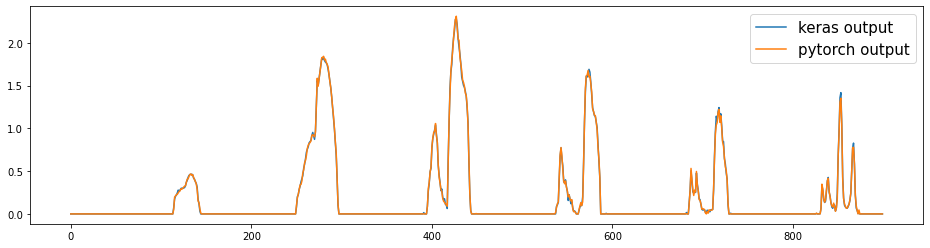

In [28]:
plt.figure(1,(16,4))
plt.plot(pred_keras[100:1000,106],label='keras output')
plt.plot(pred_pytorch.detach().numpy()[100:1000,106],label='pytorch output')
plt.legend(fontsize=15)

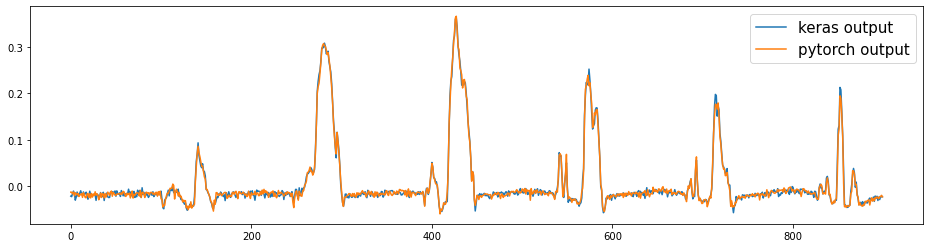

In [29]:
plt.figure(1,(16,4))
plt.plot(pred_keras[100:1000,45],label='keras output')
plt.plot(pred_pytorch.detach().numpy()[100:1000,45],label='pytorch output')
plt.legend(fontsize=15)

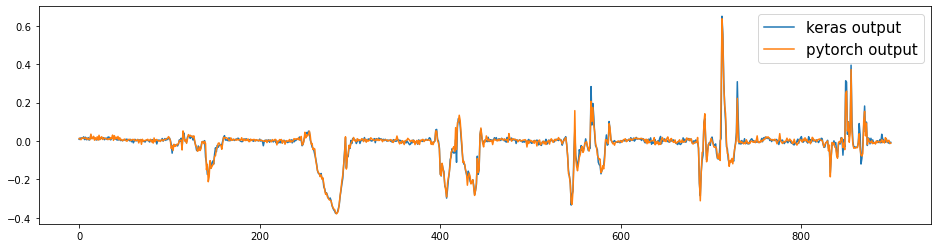

In [30]:
plt.figure(1,(16,4))
plt.plot(pred_keras[100:1000,73],label='keras output')
plt.plot(pred_pytorch.detach().numpy()[100:1000,73],label='pytorch output')
plt.legend(fontsize=15)

In [31]:
a=np.isclose(pred_keras,pred_pytorch.detach().numpy(),atol=1E-3)

In [32]:
a.shape

(13824, 113)

In [33]:
np.where(a==False)[0].size

770066

In [34]:
np.where(a==True)[0].size

792046

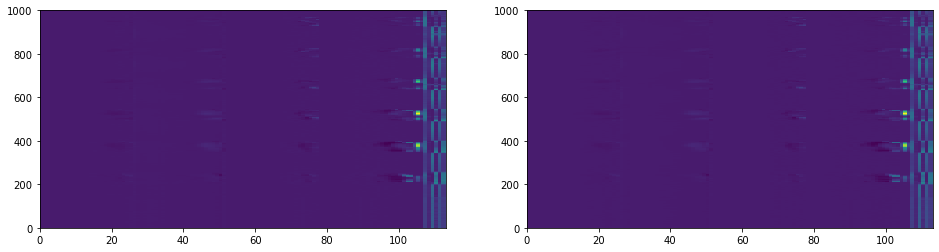

In [35]:
plt.figure(1,(16,4))
plt.subplot(1,2,1)
plt.pcolor(pred_keras[0:1000])
plt.subplot(1,2,2)
plt.pcolor(pred_pytorch.detach().numpy()[0:1000])


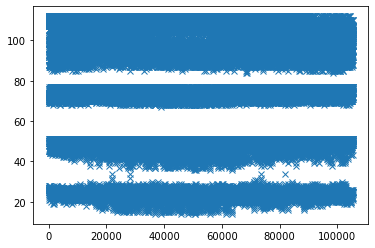

In [36]:
plt.plot(np.where(pred_keras-pred_pytorch.detach().numpy()>=1E-2)[1],'x')#np.max(pred_keras-pred_pytorch.detach().numpy()))

In [37]:
# save weights and biases of pytorch Encoder and Decoder 
to.save(Encoder_7,'real_geography/VEDs/VED_7/VEncoder_7_torch.pt')
to.save(Decoder_7,'real_geography/VEDs/VED_7/VDecoder_7_torch.pt')


In [38]:
# save entire Encoder 
enc_mod = to.jit.trace(Encoder_7, to.from_numpy(val_gen_II[300][0]))
to.jit.save(enc_mod,'real_geography/VEDs/VED_7/VEncoder_7_torch_jit.pt')

/home/b/b309162/.conda/envs/lightning_gpu_V_pytorch/lib/python3.10/site-packages/torch/jit/_trace.py:992: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 82921 / 82944 (100.0%)
Greatest absolute difference: 3.319311738014221 at index (12373, 2) (up to 1e-05 allowed)
Greatest relative difference: 10084.531486146096 at index (13555, 2) (up to 1e-05 allowed)
  _check_trace(


In [39]:
# save entire Decoder 

dec_mod = to.jit.trace(Decoder_7, Encoder_7(to.from_numpy(val_gen_II[300][0])))
to.jit.save(dec_mod,'real_geography/VEDs/VED_7/VDecoder_7_torch_jit.pt')

/home/b/b309162/.conda/envs/lightning_gpu_V_pytorch/lib/python3.10/site-packages/torch/_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1664817698971/work/build/aten/src/ATen/core/TensorBody.h:477.)
  return self._grad
